In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import export_text, DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("stress_detection.csv")
df

participant_id  day  PSS_score  Openness  Conscientiousness  \
0                  1    1         34  2.322732           4.332193   
1                  1    2         37  1.761436           3.254120   
2                  1    3         30  3.025887           1.855002   
3                  1    4         16  1.948370           4.966676   
4                  1    5         32  3.343484           2.065936   
...              ...  ...        ...       ...                ...   
2995             100   26         30  2.529821           2.339608   
2996             100   27         33  1.319100           4.500507   
2997             100   28         30  1.899102           3.930147   
2998             100   29         28  1.472408           1.712893   
2999             100   30         10  3.152789           3.633976   

      Extraversion  Agreeableness  Neuroticism  sleep_time  wake_time  \
0         1.185878       1.570213     3.782094    7.726792   5.190660   
1         3.907281       4.072512     1.997145    7.312674   6.170717   
2         2.045900       2.317493     3.619225    6.992060   5.318825   
3         3.345225       1.607756     3.583524    8.886914   8.061075   
4         3.137843       2.118061     2.567347    7.811705   7.312145   
...            ...            ...          ...         ...        ...   
2995      1.321208       4.204331     4.890738    8.823033   8.703758   
2996      4.816983       2.416180     4.195933    5.260243   5.890244   
2997      4.047799       3.163160     2.559401    6.425568   7.978066   
2998      1.245082       4.187222     4.558563    5.453843   8.859173   
2999      2.387994       3.853524     1.147076    5.270021   6.658582   

      sleep_duration  PSQI_score  call_duration  num_calls  num_sms  \
0           6.572069           1       3.924527         12       32   
1           8.030168           4      58.318004          3       41   
2           7.102420           1       4.941043          4       48   
3           8.123294           3       0.295373         11       38   
4           7.785143           3      22.300571         17       17   
...              ...         ...            ...        ...      ...   
2995        8.661936           2      59.106125          0        1   
2996        6.456058           4      56.137068         12       17   
2997        7.188921           3      58.102473         13       21   
2998        7.355107           4      44.220070         17       10   
2999        7.090551           4      36.342934         16       47   

      screen_on_time  skin_conductance  accelerometer  mobility_radius  \
0          10.703714          3.115730       0.161717         1.145179   
1          11.012939          0.959144       0.985587         1.021133   
2           4.877372          3.311629       1.877445         0.478179   
3           3.462956          0.625721       0.494921         0.630549   
4           4.861046          0.622609       1.342600         0.254090   
...              ...               ...            ...              ...   
2995       11.339248          4.045863       1.694037         0.859401   
2996       10.694380          2.169768       1.657737         0.108480   
2997        8.646478          4.995654       1.046666         0.508623   
2998        4.086836          4.897873       1.605314         0.444716   
2999        7.399881          3.279636       2.130984         1.347205   

      mobility_distance  
0              2.196851  
1              0.737825  
2              0.911673  
3              3.911418  
4              1.605132  
...                 ...  
2995           4.123621  
2996           2.242326  
2997           2.088313  
2998           4.741065  
2999           4.191338  

[3000 rows x 20 columns]

In [3]:
# Primitive cross-validation. Separating randomly has the same effect.
# df_train = df.head(2500)
# df_test = df.tail(500)
# X_train, y_train = df_train.drop(columns=["PSS_score", "participant_id", "day"]), df_train.PSS_score
# X_test, y_test = df_test.drop(columns=["PSS_score", "participant_id", "day"]), df_test['PSS_score']

In [4]:
### Actual cross validation that we plan to use ###

# Get unique participant IDs
unique_ids = df.index.unique()

# Shuffle the IDs
np.random.seed(0) # Not truly random!
shuffled_ids = np.random.permutation(unique_ids)

# Split the IDs
n_train = int(len(shuffled_ids) * 0.8)
n_val = int(len(shuffled_ids) * 0.1)
n_test = len(shuffled_ids) - n_train - n_val

train_ids = shuffled_ids[:n_train]
val_ids = shuffled_ids[n_train:n_train + n_val]
test_ids = shuffled_ids[n_train + n_val:]

# Filter rows by IDs
train_data = df[df.index.isin(train_ids)]
val_data = df[df.index.isin(val_ids)]
test_data = df[df.index.isin(test_ids)]

# Print sizes
print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")

Train size: 2400
Validation size: 300
Test size: 300


In [5]:
train_data.index.unique()

Index([   1,    2,    4,    5,    6,    8,    9,   10,   11,   12,
       ...
       2989, 2990, 2991, 2992, 2993, 2995, 2996, 2997, 2998, 2999],
      dtype='int64', length=2400)

In [6]:
test_data.index.unique()

Index([  24,   25,   67,   84,   86,   91,   94,   99,  130,  136,
       ...
       2898, 2930, 2933, 2948, 2958, 2960, 2962, 2963, 2969, 2973],
      dtype='int64', length=300)

In [7]:
val_data.index.unique()

Index([   0,    3,    7,   21,   26,   63,   93,  100,  112,  126,
       ...
       2872, 2891, 2901, 2904, 2927, 2978, 2981, 2982, 2988, 2994],
      dtype='int64', length=300)

In [8]:
X_train, y_train = train_data.drop(columns=["PSS_score", "participant_id"]), train_data.PSS_score
X_val, y_val = val_data.drop(columns=["PSS_score", "participant_id"]), val_data['PSS_score']
X_test, y_test = test_data.drop(columns=["PSS_score", "participant_id"]), test_data['PSS_score']

In [9]:
best_score = float('inf')
best_params = None
results = []

max_depth_range = range(1, 21)  # Example: 1 to 20
min_impurity_decrease_range = np.arange(0.0, 0.5, 0.05)

# Loop through each of our parameters to do grid search by hand
for max_depth in max_depth_range:
    for min_impurity_decrease in min_impurity_decrease_range:
        # Create model
        model = DecisionTreeRegressor(
            criterion='squared_error',
            max_depth=max_depth,
            min_impurity_decrease=min_impurity_decrease
        )
        model.fit(X_train, y_train)
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        val_mse = mean_squared_error(y_val, y_val_pred)
        print(f"max_depth={max_depth}; min_impurity_decrease={min_impurity_decrease:.3}; val_mse={val_mse}")
        
        # Update results
        results.append({
            'max_depth': max_depth,
            'min_impurity_decrease': min_impurity_decrease,
            'val_mse': val_mse
        })
        if val_mse < best_score:
            best_score = val_mse
            best_params = {'max_depth': max_depth, 'min_impurity_decrease': min_impurity_decrease}

results_df = pd.DataFrame(results)
print(f"Best parameters: {best_params}")
print(f"Best validation MSE: {best_score}")


max_depth=1; min_impurity_decrease=0.0; val_mse=73.33983562871018
max_depth=1; min_impurity_decrease=0.05; val_mse=73.33983562871018
max_depth=1; min_impurity_decrease=0.1; val_mse=73.33983562871018
max_depth=1; min_impurity_decrease=0.15; val_mse=73.33983562871018
max_depth=1; min_impurity_decrease=0.2; val_mse=73.33983562871018
max_depth=1; min_impurity_decrease=0.25; val_mse=73.33983562871018
max_depth=1; min_impurity_decrease=0.3; val_mse=73.04739166666667
max_depth=1; min_impurity_decrease=0.35; val_mse=73.04739166666667
max_depth=1; min_impurity_decrease=0.4; val_mse=73.04739166666667
max_depth=1; min_impurity_decrease=0.45; val_mse=73.04739166666667
max_depth=2; min_impurity_decrease=0.0; val_mse=74.28201778459974
max_depth=2; min_impurity_decrease=0.05; val_mse=74.28201778459974
max_depth=2; min_impurity_decrease=0.1; val_mse=74.28201778459974
max_depth=2; min_impurity_decrease=0.15; val_mse=74.28201778459974
max_depth=2; min_impurity_decrease=0.2; val_mse=74.28201778459974
max

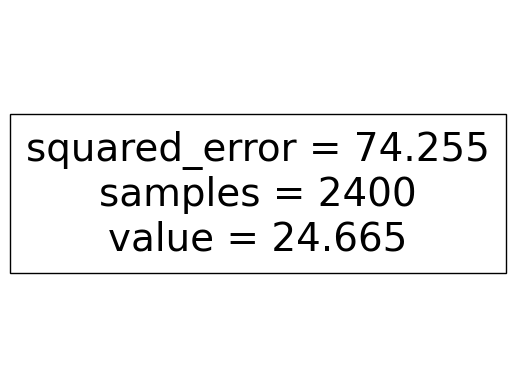

In [10]:
model = DecisionTreeRegressor(criterion='squared_error', max_depth=1, min_impurity_decrease=0.35000000000000003)
# model = DecisionTreeRegressor(criterion='squared_error', max_depth=2)
model.fit(X_train, y_train)
fig = plt.figure()
_ = tree.plot_tree(model,feature_names=X_train.columns)
# print(export_text(model, feature_names=X.columns))

# Notes from prof:
# Check MSE train and MSE test against each other
# try min_impurity_decrease in regressor
# only show first 3 layers on slides and interpret them, bigger font (make readable)
# maybe decrease max_depth as last step

In [11]:
### MSE of our model (predicting the mean for everything) on test data ###
y_test_hat = model.predict(X_test)
mean_squared_error(y_test, y_test_hat)

74.99269166666667

In [12]:
### Creating a tree with max_depth=4 performs worse than a model that guesses the mean ###
model = DecisionTreeRegressor(criterion='squared_error', max_depth=4)
model.fit(X_train, y_train)

y_model_val_hat = model.predict(X_test)
mean_squared_error(y_true=y_test, y_pred=y_model_val_hat)

75.92513512103093

In [13]:
### A linear model still does worse than guessing the mean each time ###
from sklearn.linear_model import LinearRegression
used_variables = ["Openness", "Neuroticism", "mobility_distance"]
X_train2 = X_train[used_variables]
X_test2 = X_test[used_variables]
linear_model = LinearRegression()
linear_model.fit(X_train2, y_train)
y_hat2_linear = linear_model.predict(X_test2)
mean_squared_error(y_true=y_test, y_pred=y_hat2_linear)

75.152108365599

In [14]:
df.columns

Index(['participant_id', 'day', 'PSS_score', 'Openness', 'Conscientiousness',
       'Extraversion', 'Agreeableness', 'Neuroticism', 'sleep_time',
       'wake_time', 'sleep_duration', 'PSQI_score', 'call_duration',
       'num_calls', 'num_sms', 'screen_on_time', 'skin_conductance',
       'accelerometer', 'mobility_radius', 'mobility_distance'],
      dtype='object')

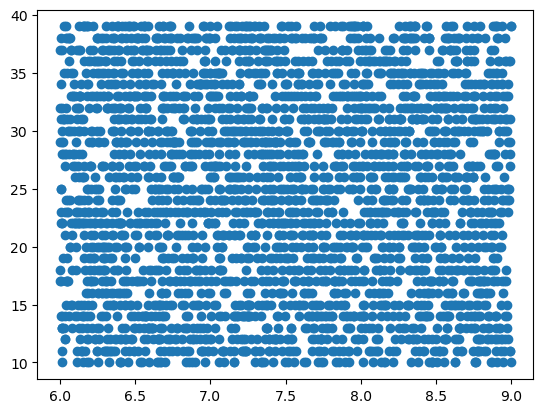

In [15]:
plt.figure()
plt.scatter(df["sleep_duration"], df["PSS_score"])

In [21]:
plt.rcParams.update({'font.size': 30})

array([[<Axes: title={'center': 'participant_id'}>,
        <Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'PSS_score'}>,
        <Axes: title={'center': 'Openness'}>],
       [<Axes: title={'center': 'Conscientiousness'}>,
        <Axes: title={'center': 'Extraversion'}>,
        <Axes: title={'center': 'Agreeableness'}>,
        <Axes: title={'center': 'Neuroticism'}>],
       [<Axes: title={'center': 'sleep_time'}>,
        <Axes: title={'center': 'wake_time'}>,
        <Axes: title={'center': 'sleep_duration'}>,
        <Axes: title={'center': 'PSQI_score'}>],
       [<Axes: title={'center': 'call_duration'}>,
        <Axes: title={'center': 'num_calls'}>,
        <Axes: title={'center': 'num_sms'}>,
        <Axes: title={'center': 'screen_on_time'}>],
       [<Axes: title={'center': 'skin_conductance'}>,
        <Axes: title={'center': 'accelerometer'}>,
        <Axes: title={'center': 'mobility_radius'}>,
        <Axes: title={'center': 'mobility_distance'}>]], 

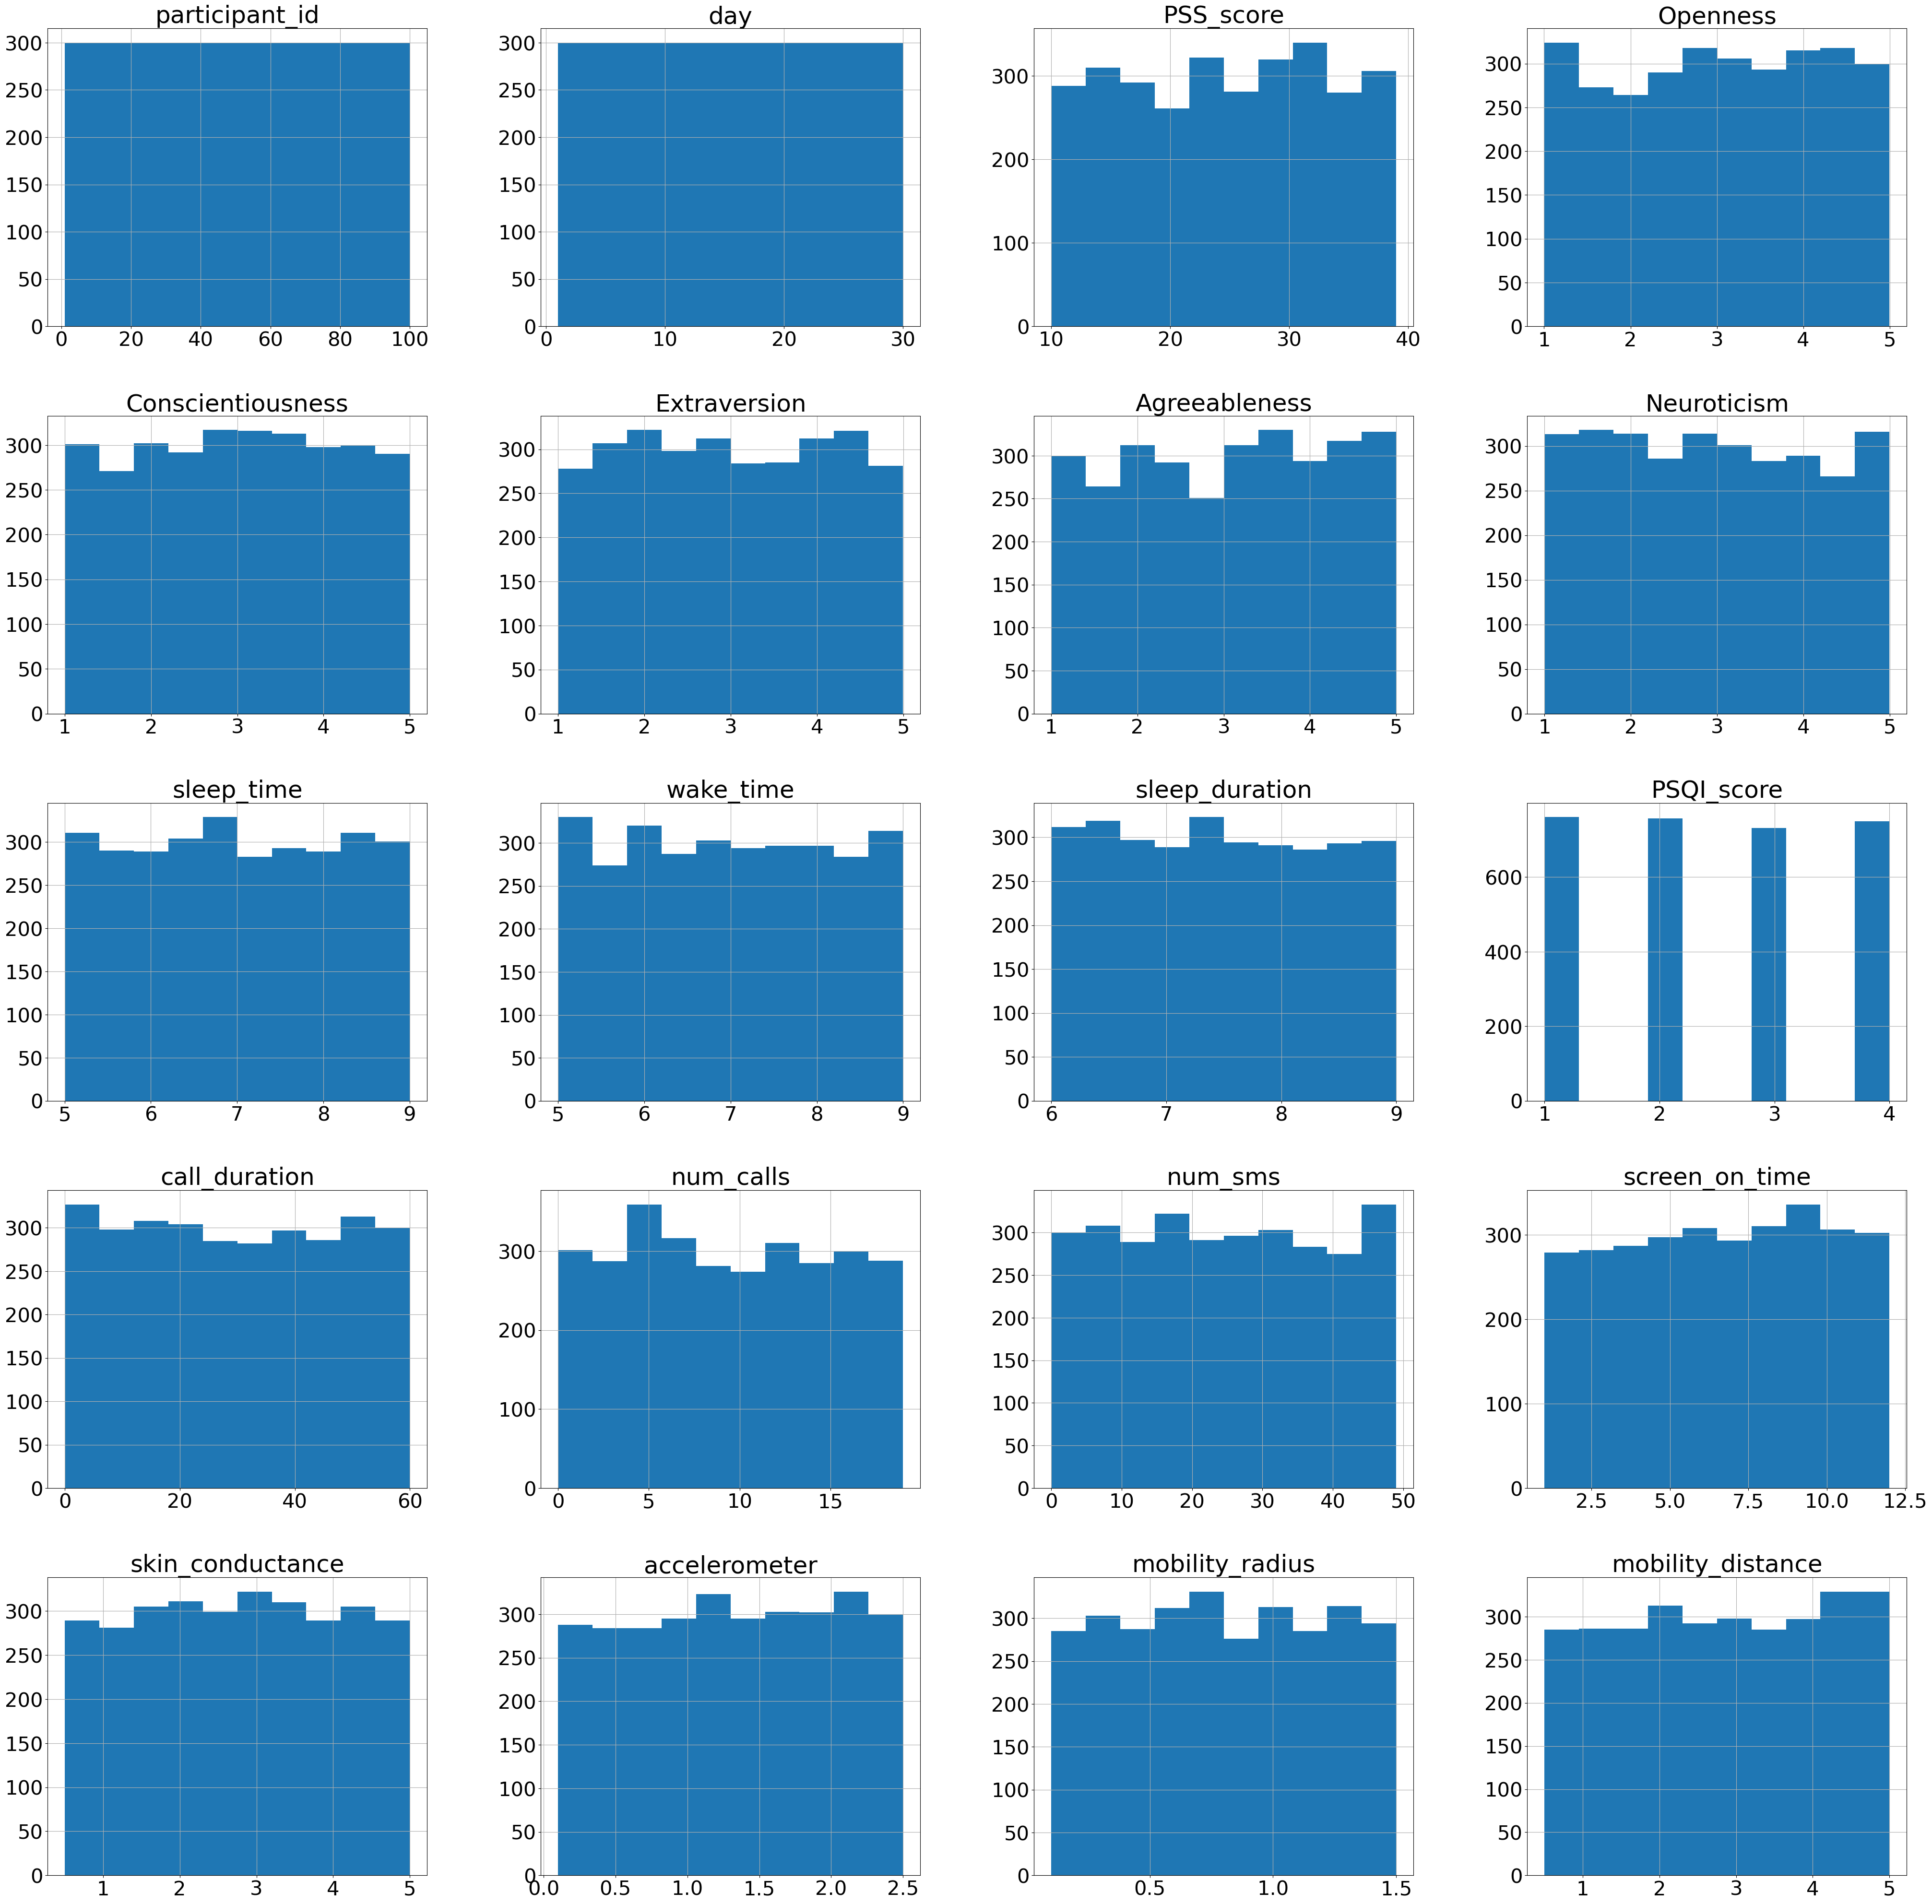

In [24]:
df.hist(figsize=(50, 50))

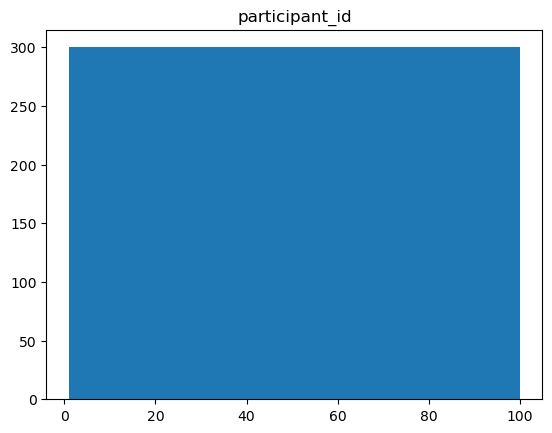

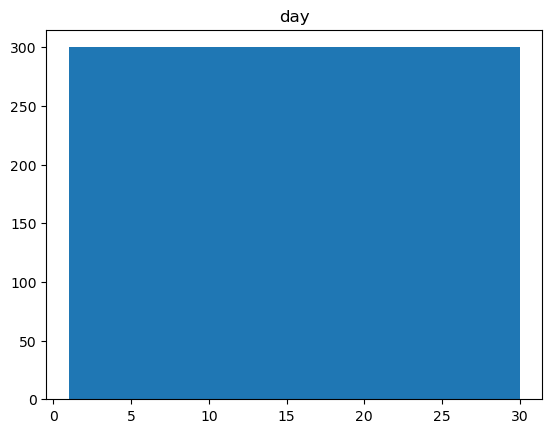

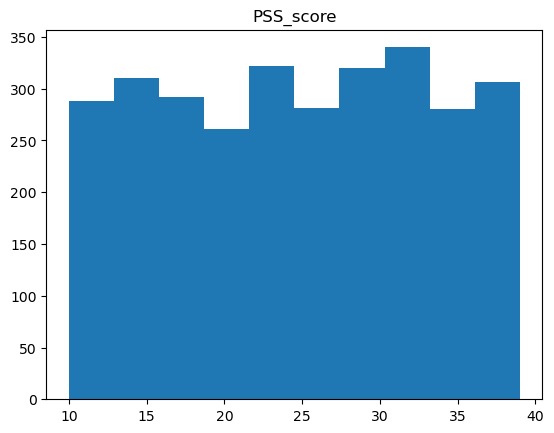

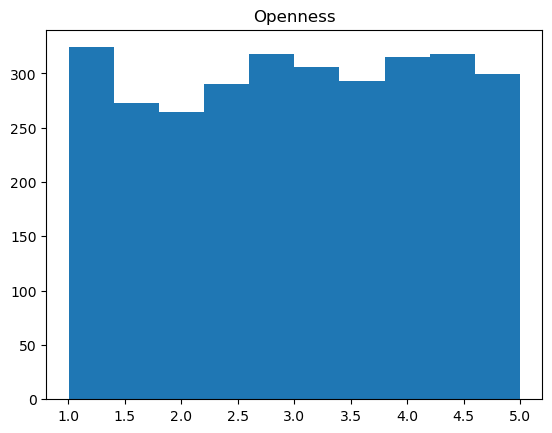

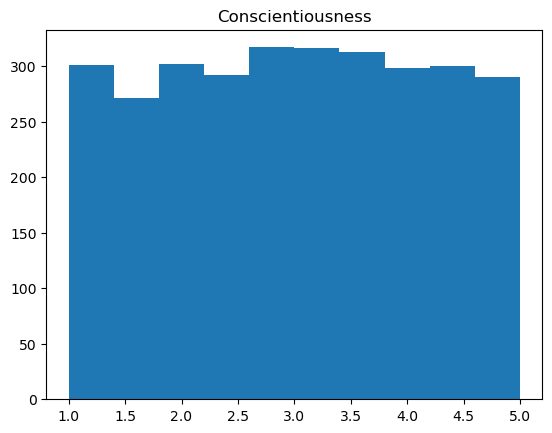

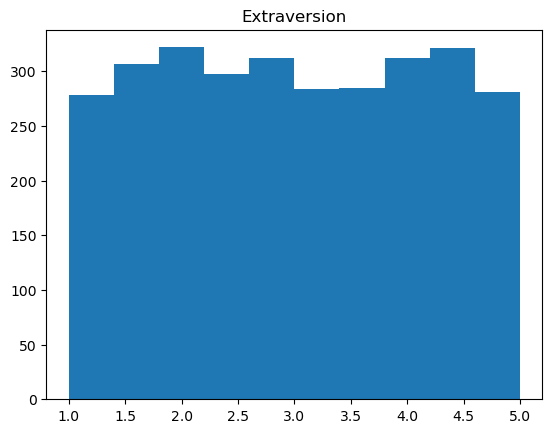

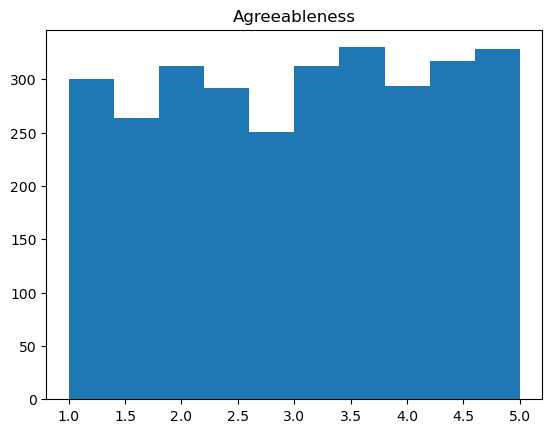

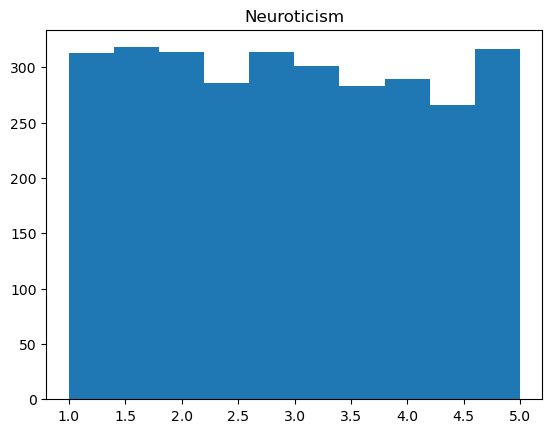

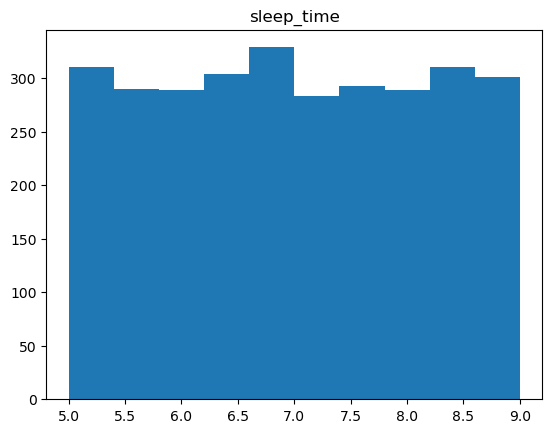

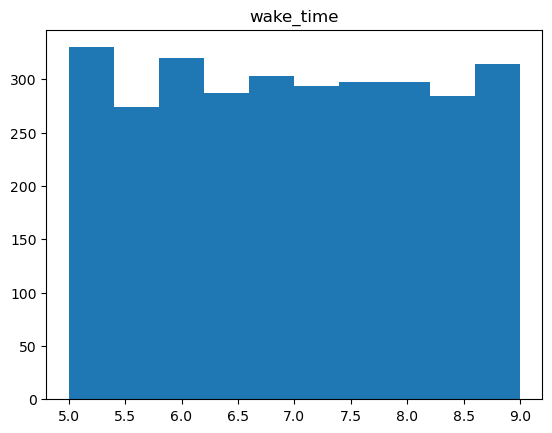

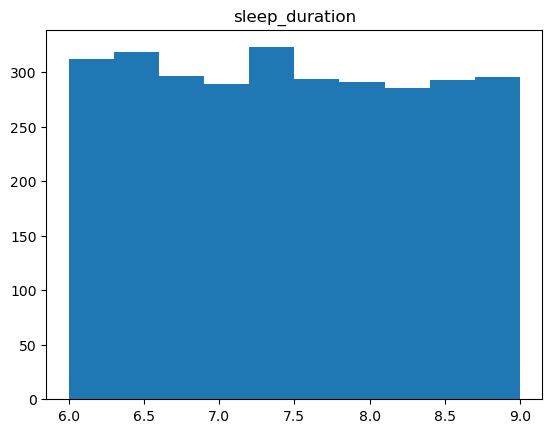

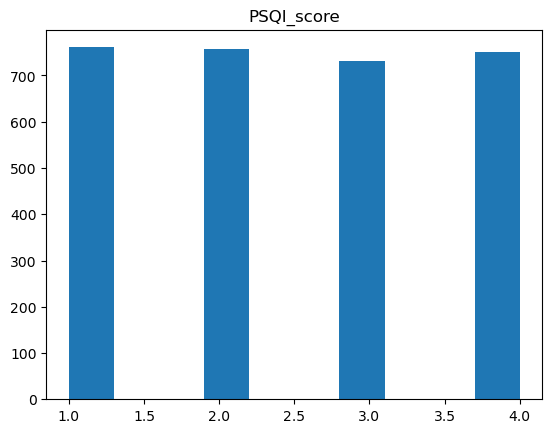

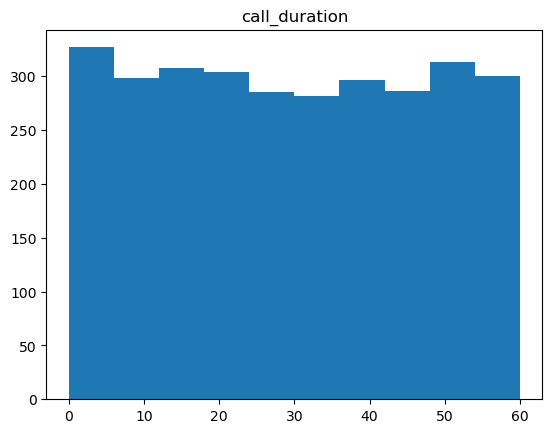

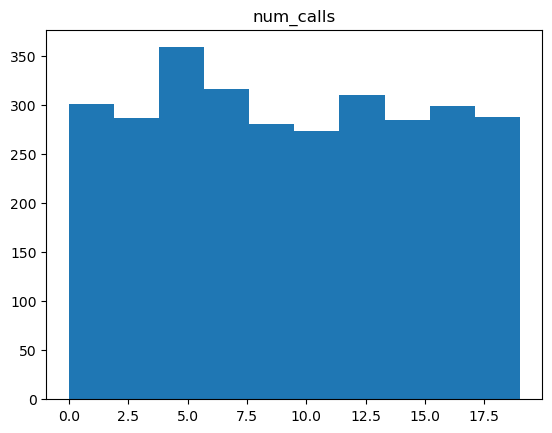

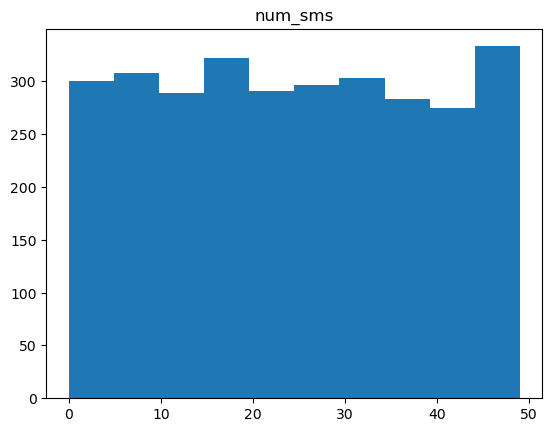

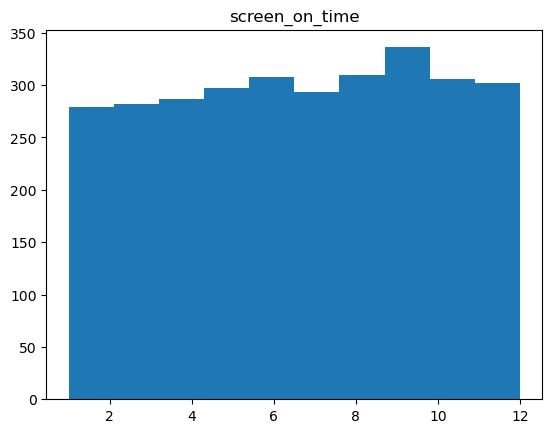

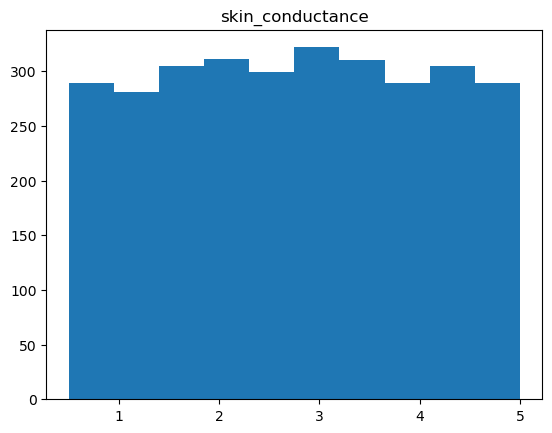

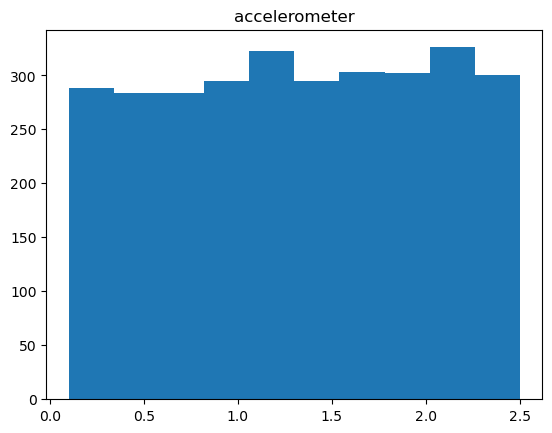

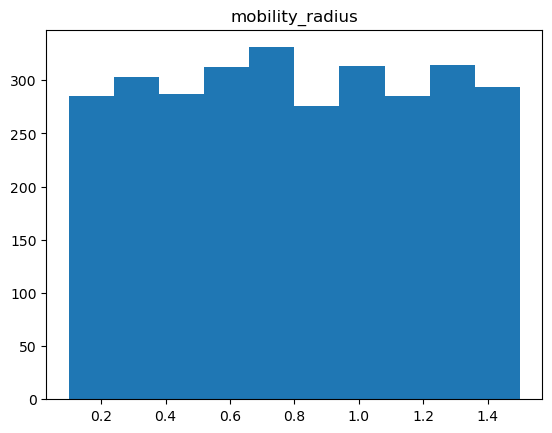

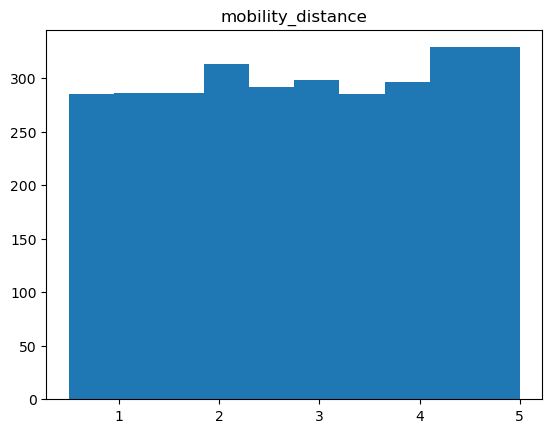

In [17]:
import statistics
for var in df.columns:
    # print(f"Var: {var}, sd={statistics.
    # stdev(df[var])}")
    plt.figure()
    plt.hist(df[var], bins=10)
    plt.title(var)

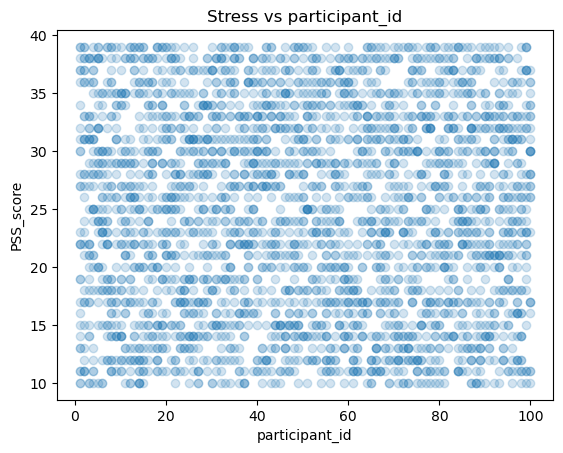

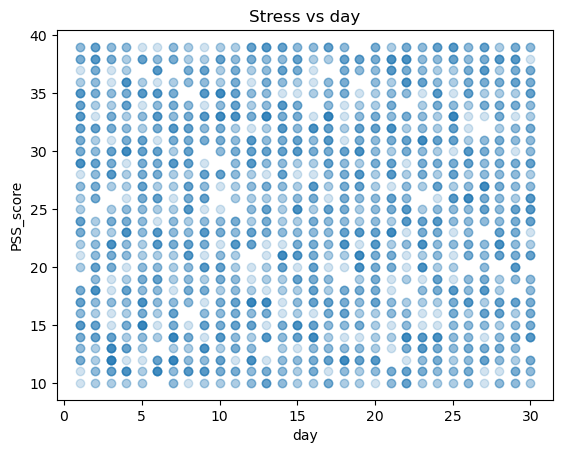

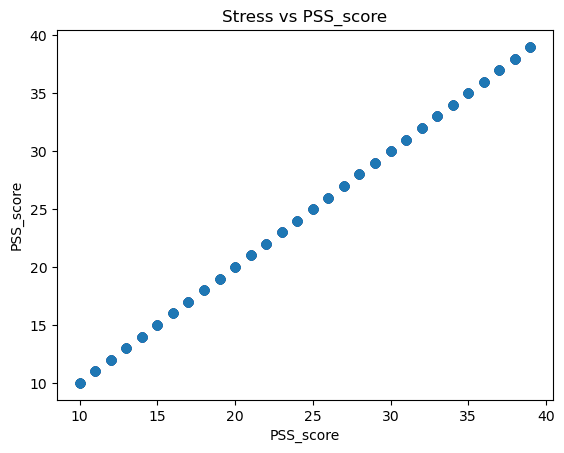

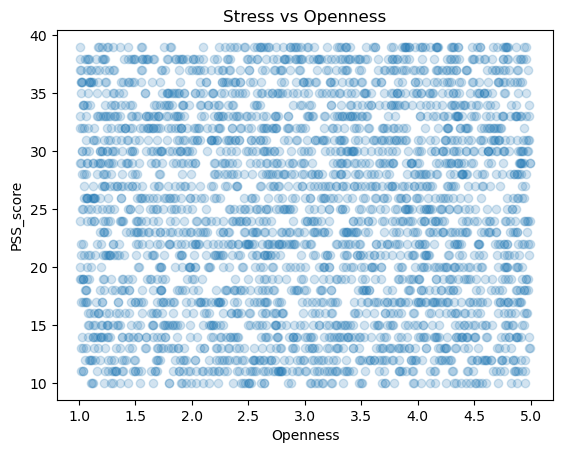

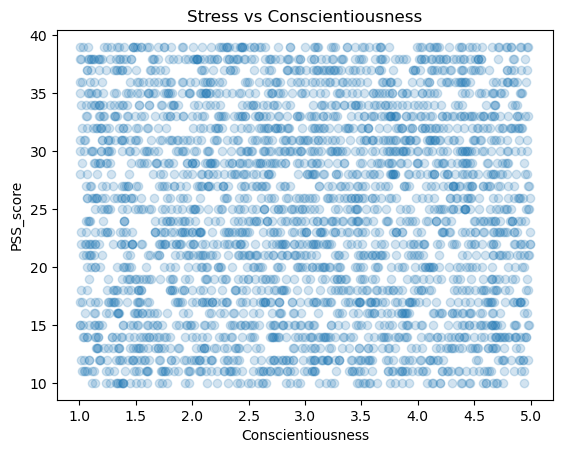

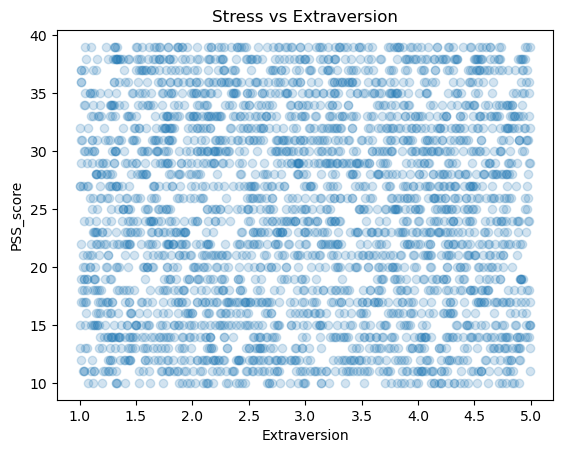

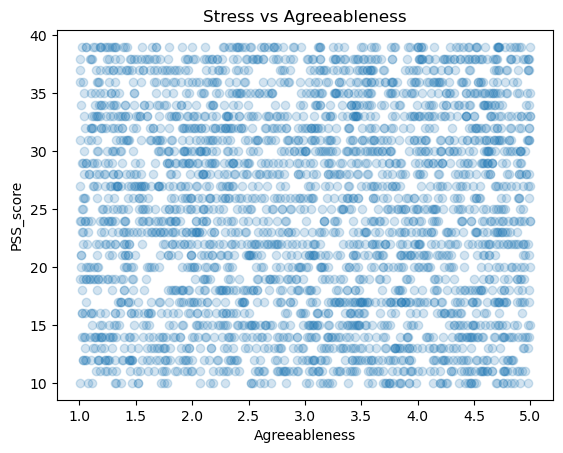

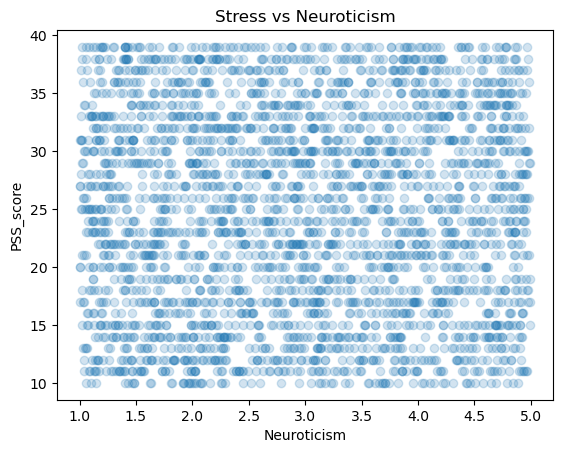

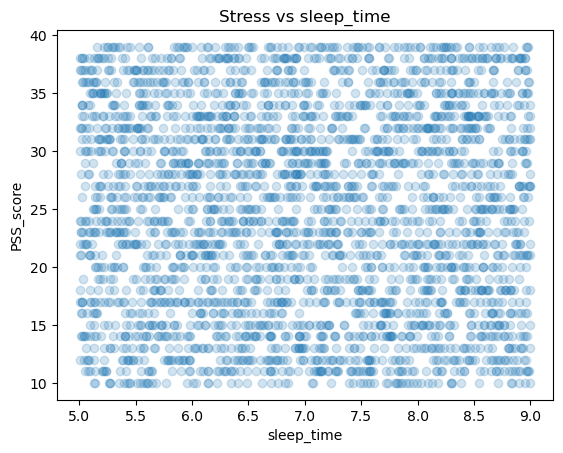

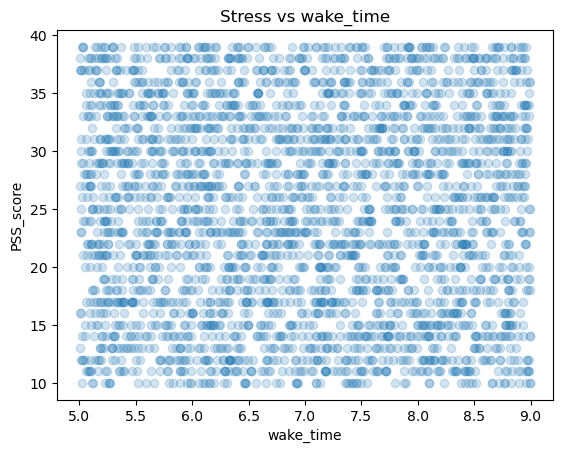

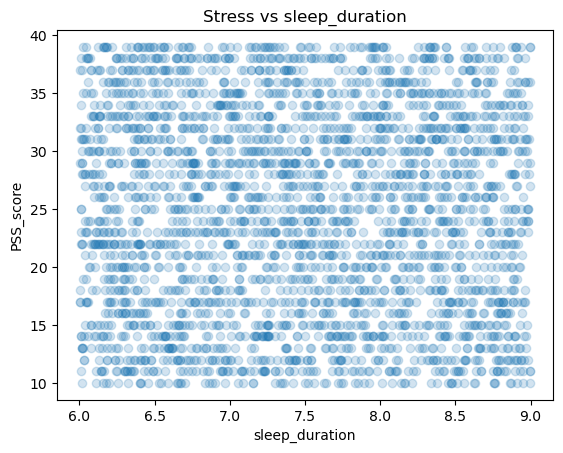

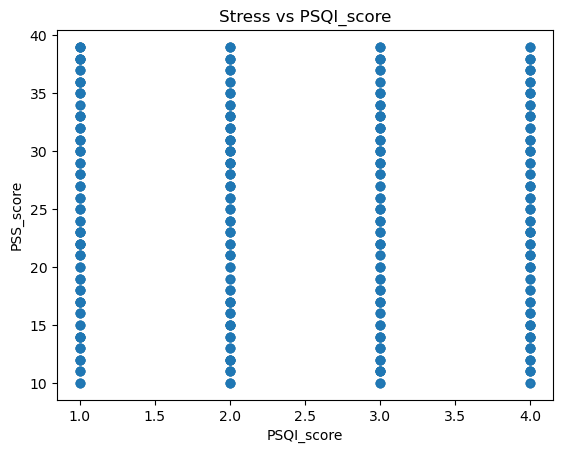

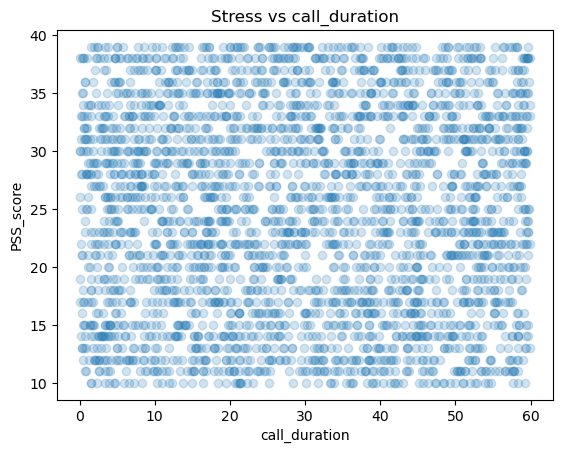

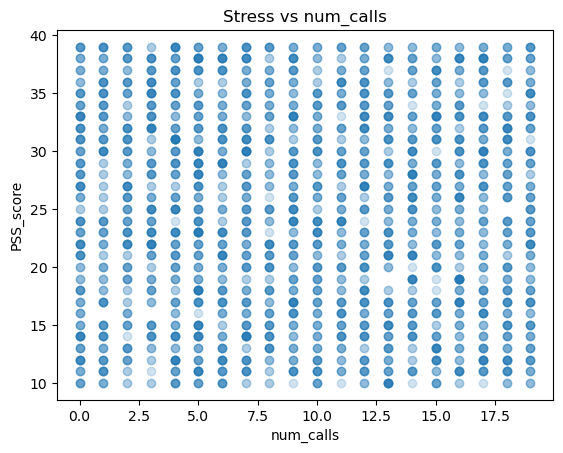

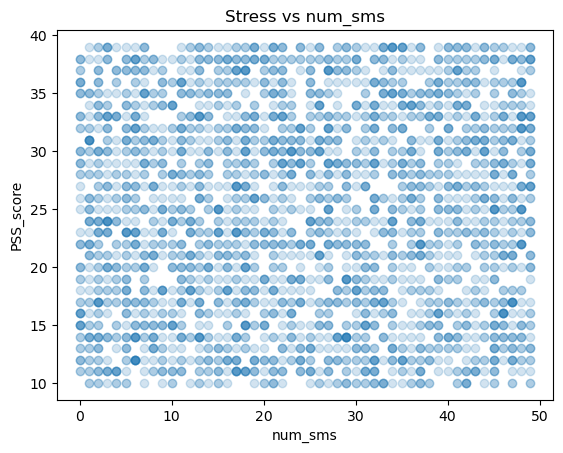

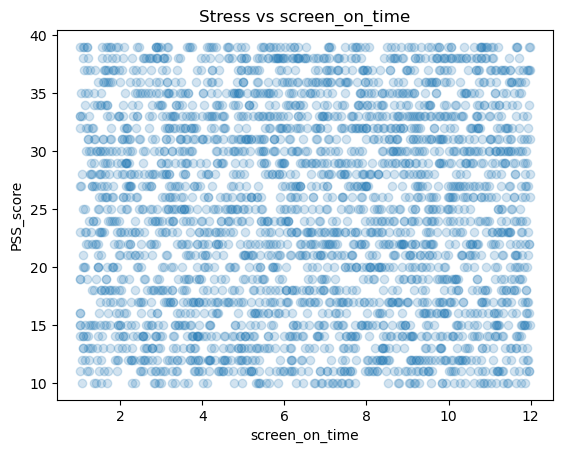

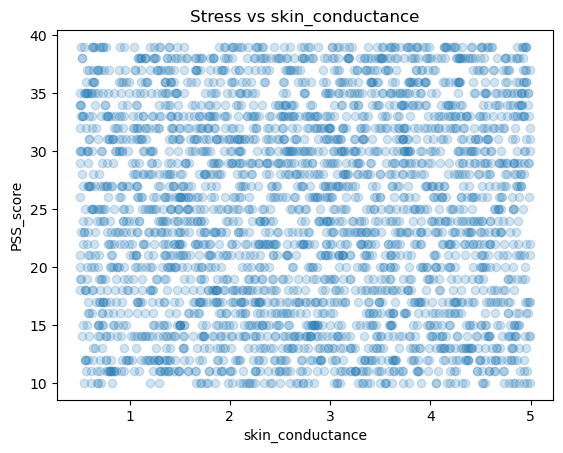

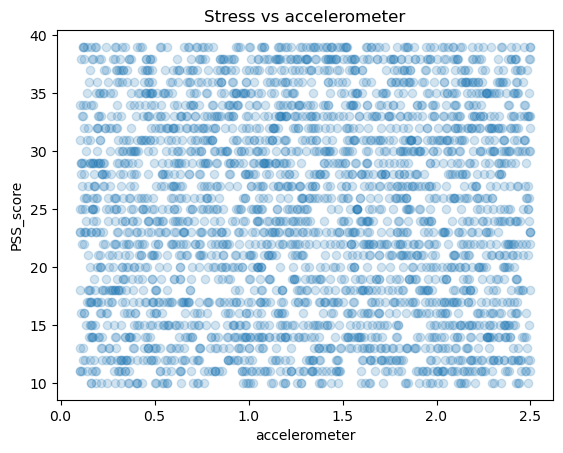

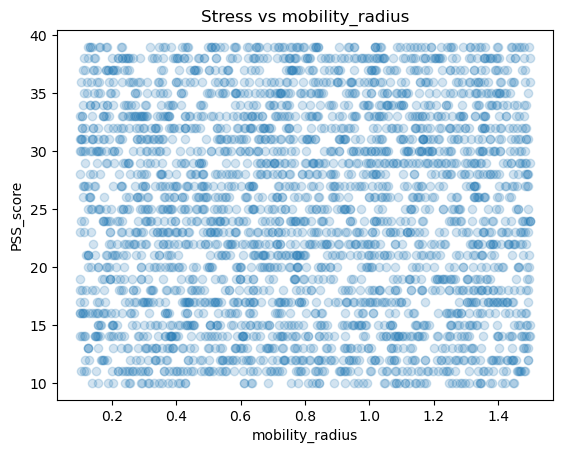

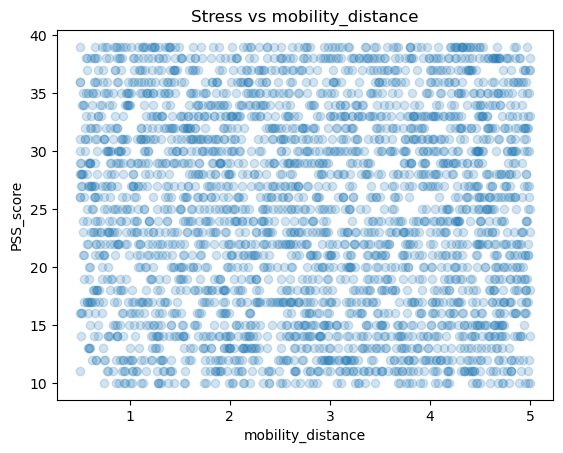

In [18]:
for var in df.columns:
    plt.figure()
    plt.title(f"Stress vs {var}")
    plt.xlabel(var)
    plt.ylabel("PSS_score")
    plt.scatter(df[var], df["PSS_score"], alpha=0.2)

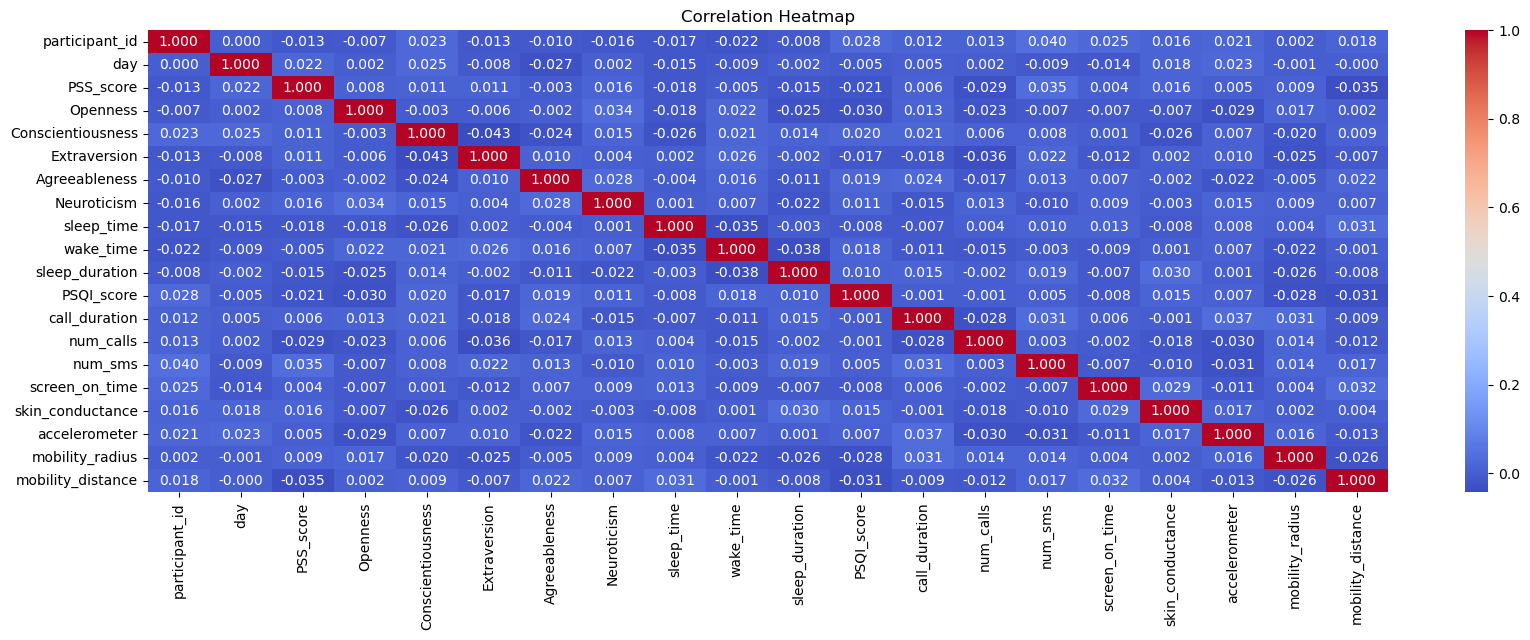

In [19]:
import seaborn as sns
corr = df.corr()
s = corr.style.background_gradient(cmap='coolwarm')
plt.figure(figsize=(20, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Correlation Heatmap')
plt.savefig('heatmap.png')